# Decision Tree Classifier Project #

### Importing libraries ###

In [3]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

### Importing Dataset, preprocessing and creating Training and Test sets ###

In [4]:
df = pd.read_csv('secondary_data.csv', sep=";")

#sostituiamo i none value con degli 0
df = df.fillna(0)

#preprocessing: convertiamo i valori categorici in numerici
df = df.apply(lambda col: pd.factorize(col)[0])

def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df

In [5]:
random.seed(22)
train_df, test_df = train_test_split(df, test_size=0.1)

X_train,X_test = train_df.drop("class", axis=1).to_numpy(), test_df.drop("class", axis=1).to_numpy()
y_train,y_test = train_df["class"].to_numpy(), test_df["class"].to_numpy()

### Defining Node Class ###

In [6]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left_child=None, right_child=None, prediction=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left_child = left_child
        self.right_child = right_child
        self.prediction = prediction

    def classify(self, x):
        if self.prediction is not None:
            return self.prediction

        if x[self.feature_index] < self.threshold:
            return self.left_child.classify(x)
        else:
            return self.right_child.classify(x)


### Defining splitting criteria ###

In [7]:
def gini_impurity(y):
    classes, counts = np.unique(y, return_counts=True)
    probas = counts / len(y)
    return 1 - np.sum(probas ** 2)

def entropy(y):
    classes, counts = np.unique(y, return_counts=True)
    probas = counts / len(y)
    return -np.sum(probas * np.log2(probas))

def misclassification_error(y):
    majority_class_count = np.max(np.bincount(y))
    return 1 - majority_class_count / len(y)

### Defining TreePredictor Class ###

In [8]:
class TreePredictor:
    def __init__(self, max_depth=5, min_samples_split=2, split_criterion='gini'):
        self.root = None
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.split_criterion = split_criterion
    
    def build_tree(self, X, y, depth):
        
        n_samples, n_features = np.shape(X)
        if depth >= self.max_depth or n_samples < self.min_samples_split or len(np.unique(y)) == 1:
            leaf_value = self.majority_class(y)
            return Node(prediction=leaf_value)
        
        best_feature, best_threshold = self.find_best_split(X, y)

        if best_feature is None:
            leaf_value = self.majority_class(y)
            return Node(prediction=leaf_value)

        node = Node(feature_index=best_feature, threshold=best_threshold)

        left_idx = X[:, best_feature] < best_threshold
        right_idx = ~left_idx

        
        node.left_child = self.build_tree(X[left_idx], y[left_idx], depth + 1)
        node.right_child = self.build_tree(X[right_idx], y[right_idx], depth + 1)

        return node

    def find_best_split(self, X, y):
        best_feature, best_threshold, best_impurity = None, None, float('inf')
        current_impurity = self.calculate_impurity(y)

        for feature_idx in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left = X[:, feature_idx] < threshold
                right = ~left

                if np.sum(left) > 0 and np.sum(right) > 0:
                    left_impurity = self.calculate_impurity(y[left])
                    right_impurity = self.calculate_impurity(y[right])
                    impurity = (np.sum(left) * left_impurity + np.sum(right) * right_impurity) / len(y)

                    if impurity < best_impurity:
                        best_impurity = impurity
                        best_feature = feature_idx
                        best_threshold = threshold

        return best_feature, best_threshold

    def calculate_impurity(self, y):
        if self.split_criterion == 'gini':
            return gini_impurity(y)
        elif self.split_criterion == 'entropy':
            return entropy(y)
        elif self.split_criterion == 'misclassification':
            return misclassification_error(y)
        else:
            raise ValueError(f"Invalid splitting criterion: {self.split_criterion}")

    def majority_class(self, y):
        return np.bincount(y).argmax()
    
    def fit(self, X, y):
        self.root = self.build_tree(X, y, depth=0)

    def predict(self, X):
        return np.array([self.root.classify(x) for x in X])

    def evaluate(self, X, y):
        predictions = self.predict(X)
        loss = np.mean(predictions != y)
        return loss

### Hyperparameters Tuning and Evaluating ###

In [9]:

tree = TreePredictor(max_depth=5, min_samples_split=10, split_criterion='gini')
tree.fit(X_train, y_train)

train_error = tree.evaluate(X_train, y_train)
test_error = tree.evaluate(X_test, y_test)

print(f"Train error: {train_error * 100:.2f}%")
print(f"Test error: {test_error * 100:.2f}%")

Training Accuracy: 22.48%
Testing Accuracy: 23.01%


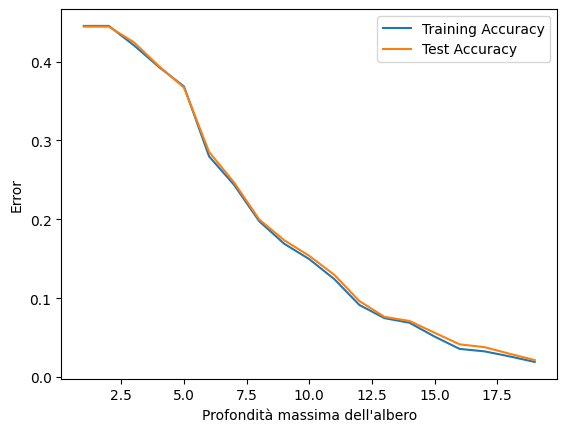

In [10]:
training_scores = []
test_scores = []


for depth in range(1, 20):
    tree = TreePredictor(max_depth=depth, min_samples_split=10, split_criterion='entropy')
    tree.fit(X_train, y_train)
    
    
    train_error = tree.evaluate(X_train, y_train)
    training_scores.append(train_error)
    
    
    test_error = tree.evaluate(X_test, y_test)
    test_scores.append(test_error)


plt.plot(range(1, 20), training_scores, label='Training error')
plt.plot(range(1, 20), test_scores, label='Test error')
plt.xlabel('Profondità massima dell\'albero')
plt.ylabel('Error')
plt.legend()
plt.show()

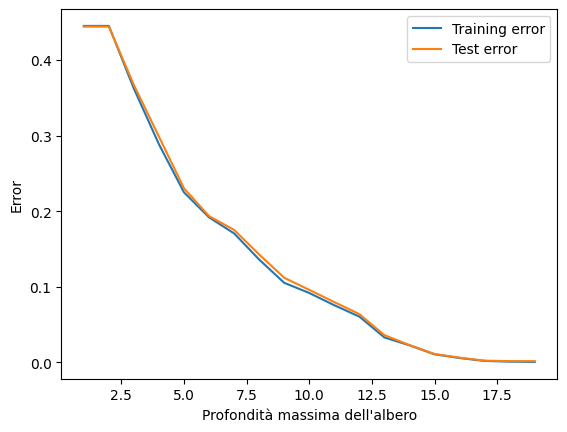

In [11]:
training_scores = []
test_scores = []


for depth in range(1, 20):
    tree = TreePredictor(max_depth=depth, min_samples_split=10, split_criterion='gini')
    tree.fit(X_train, y_train)
    
 
    train_error = tree.evaluate(X_train, y_train)
    training_scores.append(train_error)
    
  
    test_error = tree.evaluate(X_test, y_test)
    test_scores.append(test_error)


plt.plot(range(1, 20), training_scores, label='Training error')
plt.plot(range(1, 20), test_scores, label='Test error')
plt.xlabel('Profondità massima dell\'albero')
plt.ylabel('Error')
plt.legend()
plt.show()

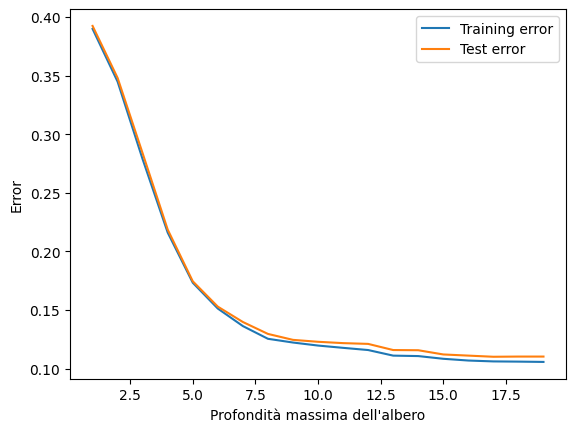

In [13]:
training_scores = []
test_scores = []


for depth in range(1, 20):
    tree = TreePredictor(max_depth=depth, min_samples_split=10, split_criterion='misclassification')
    tree.fit(X_train, y_train)
    
    
    train_error = tree.evaluate(X_train, y_train)
    training_scores.append(train_error)
    
    
    test_error = tree.evaluate(X_test, y_test)
    test_scores.append(test_error)


plt.plot(range(1, 20), training_scores, label='Training error')
plt.plot(range(1, 20), test_scores, label='Test error')
plt.xlabel('Profondità massima dell\'albero')
plt.ylabel('Error')
plt.legend()
plt.show()

In [14]:
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'split_criterion': ['gini', 'entropy', 'misclassification']
}

def hyperparameter_tuning(X_train, y_train, X_test, y_test, param_grid):
    
    best_params = None
    best_loss = float('inf') 
    
    
    for max_depth in param_grid['max_depth']:
        for min_samples_split in param_grid['min_samples_split']:
            for split_criterion in param_grid['split_criterion']:
                print(f"Testando: max_depth={max_depth}, min_samples_split={min_samples_split}, split_criterion={split_criterion}")
                
                
                tree = TreePredictor(max_depth=max_depth, min_samples_split=min_samples_split, split_criterion=split_criterion)
                tree.fit(X_train, y_train)
                
                
                loss = tree.evaluate(X_test, y_test)
                print(f"Loss: {loss}")
                
                
                if loss < best_loss:
                    best_loss = loss
                    best_params = {
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'split_criterion': split_criterion
                    }
    
    return best_params, best_loss


best_params, best_loss = hyperparameter_tuning(X_train, y_train, X_test, y_test, param_grid)
print(f"Migliori parametri trovati: {best_params} con loss={best_loss}")


Testando: max_depth=5, min_samples_split=2, split_criterion=gini
Loss: 0.23006386114295072
Testando: max_depth=5, min_samples_split=2, split_criterion=entropy
Loss: 0.36695595218601607
Testando: max_depth=5, min_samples_split=2, split_criterion=misclassification
Loss: 0.17455379073194693
Testando: max_depth=5, min_samples_split=5, split_criterion=gini
Loss: 0.23006386114295072
Testando: max_depth=5, min_samples_split=5, split_criterion=entropy
Loss: 0.36695595218601607
Testando: max_depth=5, min_samples_split=5, split_criterion=misclassification
Loss: 0.17455379073194693
Testando: max_depth=5, min_samples_split=10, split_criterion=gini
Loss: 0.23006386114295072
Testando: max_depth=5, min_samples_split=10, split_criterion=entropy
Loss: 0.36695595218601607
Testando: max_depth=5, min_samples_split=10, split_criterion=misclassification
Loss: 0.17455379073194693
Testando: max_depth=10, min_samples_split=2, split_criterion=gini
Loss: 0.09579171442606844
Testando: max_depth=10, min_samples_sp